In [1]:
!pip install xgboost
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0335d9073916b01569786eb8b31e1faac8bc69dbffff87607fdd314210418393
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [2]:
!cp -r drive/MyDrive/Data .

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import *

In [12]:
def get_emb(name, text):
    if name=='tf-idf':
        all_text = np.concatenate([text['train'], text['test']])
        vectorizer = TfidfVectorizer()
        emb = vectorizer.fit_transform(all_text)
        return emb[:text['train'].shape[0]], emb[text['train'].shape[0]:]
    elif name=='labse':
        labse_model = SentenceTransformer('sentence-transformers/LaBSE')
        emb = labse_model.encode(text)
        return emb

In [7]:
df_x_train, df_y_train, df_x_val, df_y_val, df_x_test = load_data()

In [8]:
df_x_train['text'] = df_x_train['Conclusion']+' '+df_x_train['Stance']+' '+df_x_train['Premise']
df_x_val['text'] = df_x_val['Conclusion']+' '+df_x_val['Stance']+' '+df_x_val['Premise']
df_x_train['text'] = df_x_train['text'].str.lower()
df_x_val['text'] = df_x_val['text'].str.lower()
x_train = df_x_train['text'].to_numpy()
x_val = df_x_val['text'].to_numpy()
y_train = df_y_train.loc[:, df_y_train.columns != 'Argument ID'].to_numpy()
y_val = df_y_val.loc[:, df_y_val.columns != 'Argument ID'].to_numpy()

In [9]:
train_emb = get_emb('labse', x_train)
val_emb = get_emb('labse', x_val)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

In [10]:
import xgboost as xgb

xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')

multilabel_model = MultiOutputClassifier(xgb_estimator)

multilabel_model.fit(train_emb, y_train)

y_val_pred = multilabel_model.predict(val_emb)

,0
f1-macro,0.225066
f1-micro,0.375070
f1-weighted,0.333354
f1 on class Self-direction: thought,0.210884
f1 on class Self-direction: action,0.371960
f1 on class Stimulation,0.000000
f1 on class Hedonism,0.108108
f1 on class Achievement,0.527964
f1 on class Power: dominance,0.023121
f1 on class Power: resources,0.184049


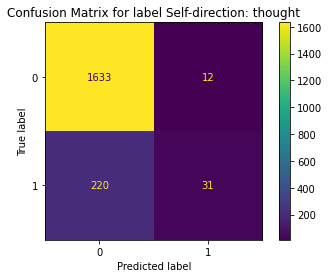

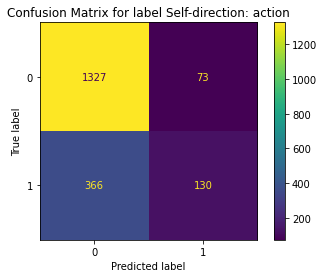

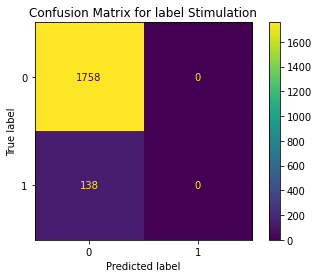

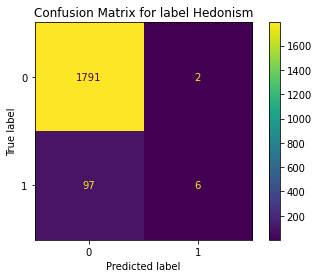

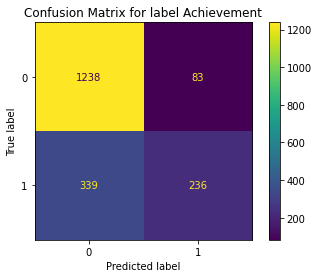

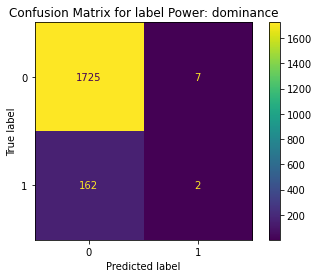

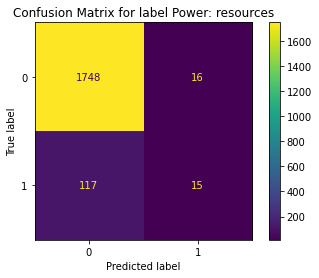

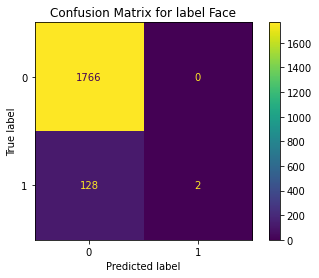

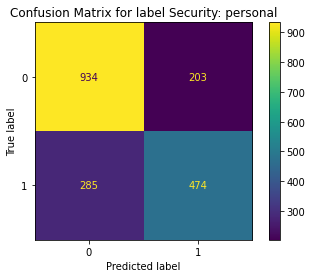

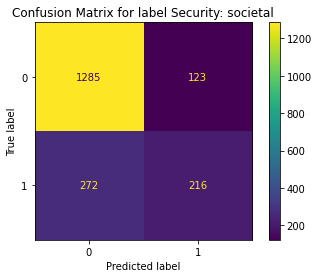

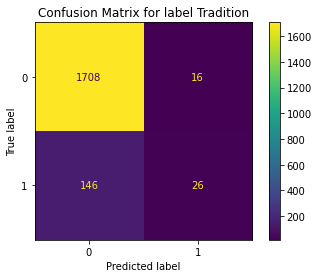

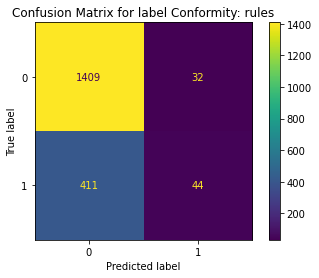

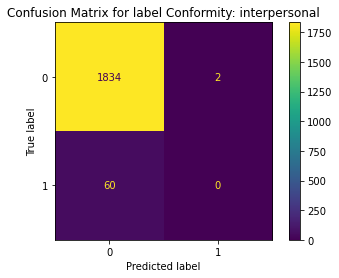

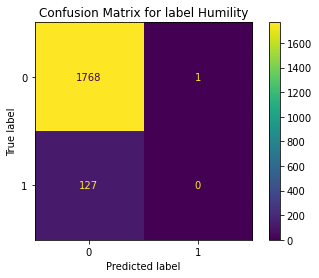

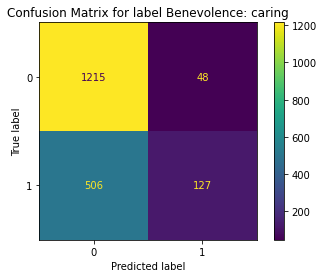

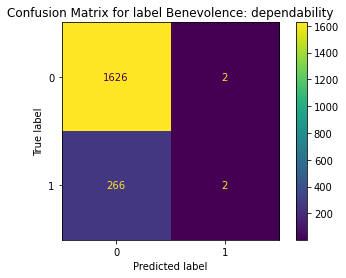

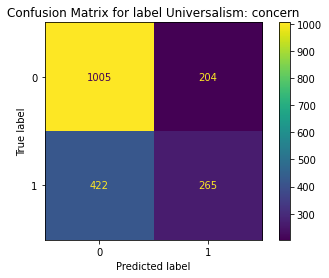

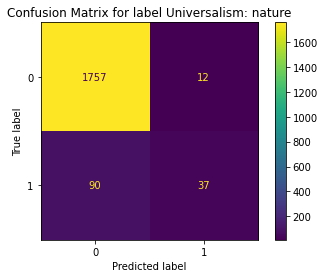

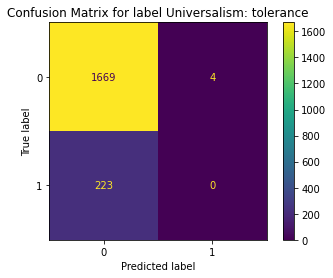

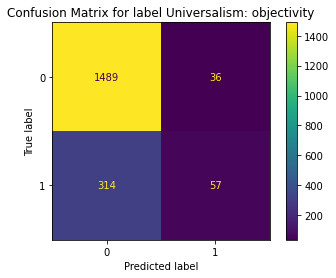

In [11]:
!rm -rf XGboost-labse
evaluate('XGboost-labse', y_val_pred, y_val)

In [14]:
train_emb, val_emb = get_emb('tf-idf', {'train':x_train, 'test':x_val})

In [15]:
import xgboost as xgb

xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')

multilabel_model = MultiOutputClassifier(xgb_estimator)

multilabel_model.fit(train_emb, y_train)

y_val_pred = multilabel_model.predict(val_emb)

,0
f1-macro,0.119292
f1-micro,0.191261
f1-weighted,0.179908
f1 on class Self-direction: thought,0.118959
f1 on class Self-direction: action,0.342949
f1 on class Stimulation,0.000000
f1 on class Hedonism,0.000000
f1 on class Achievement,0.255507
f1 on class Power: dominance,0.011976
f1 on class Power: resources,0.083333


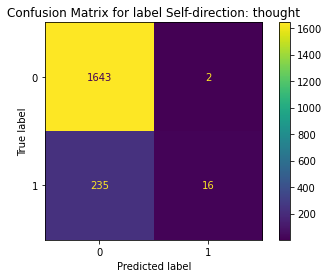

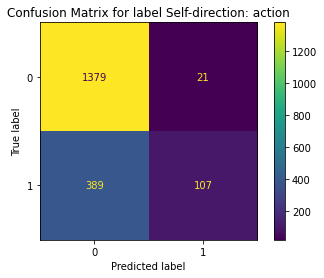

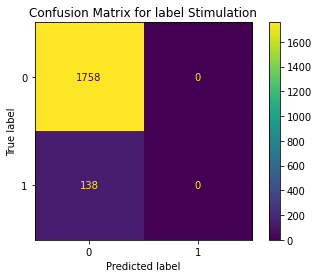

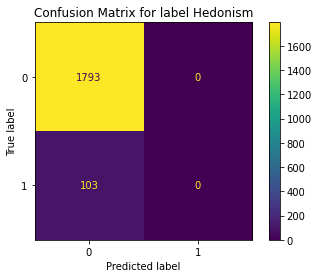

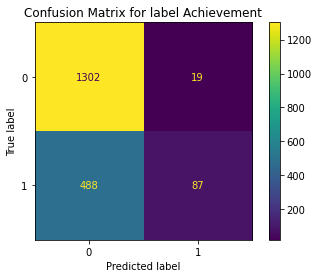

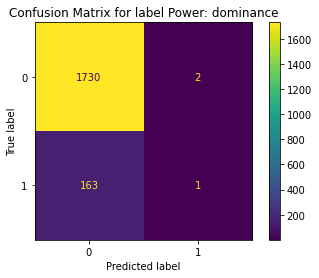

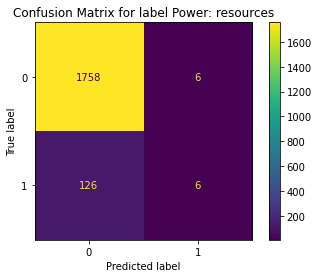

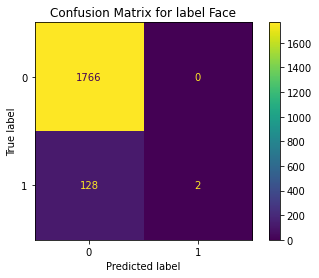

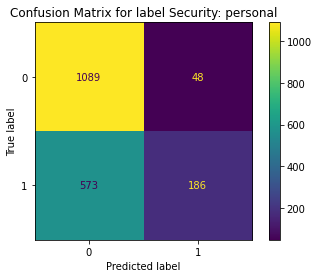

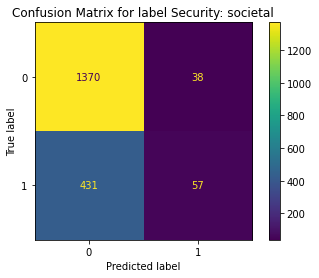

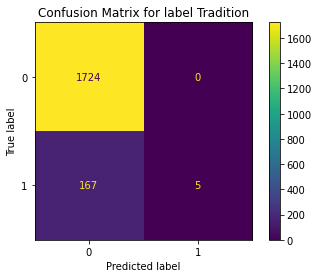

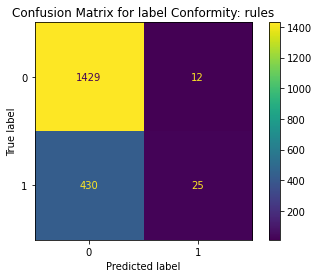

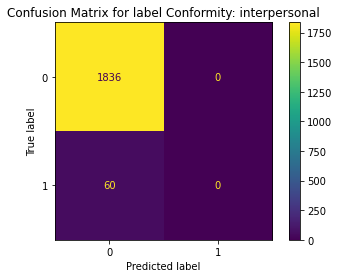

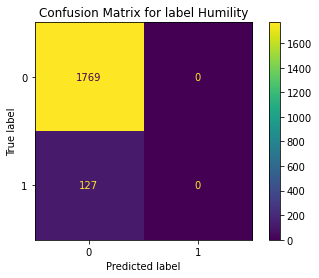

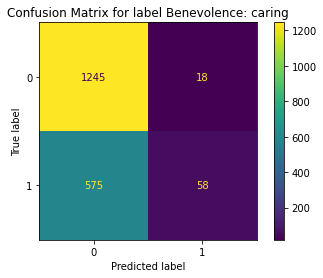

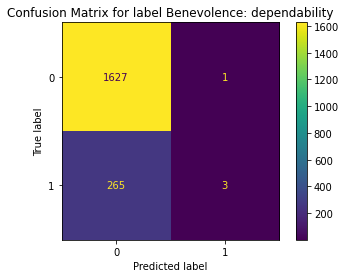

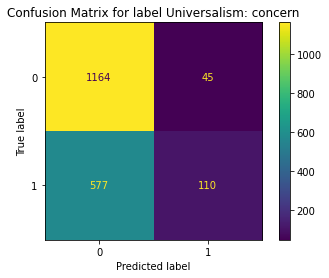

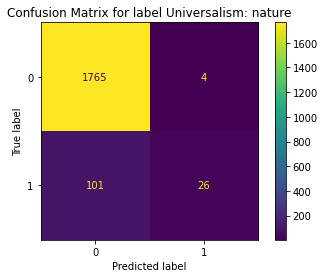

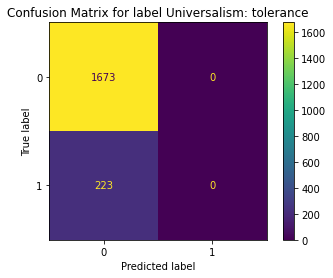

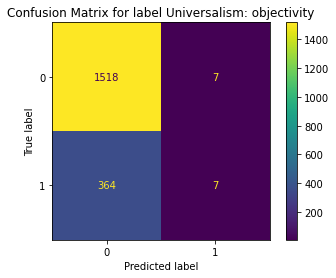

In [16]:
!rm -rf XGboost-tfidf
evaluate('XGboost-tfidf', y_val_pred, y_val)

In [17]:
!zip -r XGboost-labse.zip XGboost-labse

  adding: XGboost-labse/ (stored 0%)
  adding: XGboost-labse/res.tex (deflated 68%)
  adding: XGboost-labse/Confusion_Universalism: nature.png (deflated 9%)
  adding: XGboost-labse/Confusion_Tradition.png (deflated 9%)
  adding: XGboost-labse/Confusion_Universalism: concern.png (deflated 9%)
  adding: XGboost-labse/Confusion_Power: resources.png (deflated 9%)
  adding: XGboost-labse/Confusion_Self-direction: action.png (deflated 9%)
  adding: XGboost-labse/Confusion_Stimulation.png (deflated 9%)
  adding: XGboost-labse/Confusion_Conformity: rules.png (deflated 9%)
  adding: XGboost-labse/Confusion_Security: personal.png (deflated 9%)
  adding: XGboost-labse/Confusion_Benevolence: dependability.png (deflated 9%)
  adding: XGboost-labse/Confusion_Face.png (deflated 9%)
  adding: XGboost-labse/Confusion_Security: societal.png (deflated 9%)
  adding: XGboost-labse/Confusion_Universalism: tolerance.png (deflated 9%)
  adding: XGboost-labse/Confusion_Benevolence: caring.png (deflated 9%)
  a

In [18]:
!zip -r XGboost-tfidf.zip XGboost-tfidf

  adding: XGboost-tfidf/ (stored 0%)
  adding: XGboost-tfidf/res.tex (deflated 68%)
  adding: XGboost-tfidf/Confusion_Universalism: nature.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Tradition.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Universalism: concern.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Power: resources.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Self-direction: action.png (deflated 10%)
  adding: XGboost-tfidf/Confusion_Stimulation.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Conformity: rules.png (deflated 8%)
  adding: XGboost-tfidf/Confusion_Security: personal.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Benevolence: dependability.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Face.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Security: societal.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Universalism: tolerance.png (deflated 9%)
  adding: XGboost-tfidf/Confusion_Benevolence: caring.png (deflated 8%)
  